# Segmentation of the Liver in CT slices

In [1]:
##### Import Libraries #####
## Keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History

## skimage
from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Other
import os
from os import walk
import numpy as np
import nibabel
import math
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Data Preparation

In [2]:
##### Import Data #####
## Base Paths
pathInputs = ('C:/Users/ianco/Documents/Deep Learning Datasets/LiverSegmentation/Inputs')
pathMasks = ('C:/Users/ianco/Documents/Deep Learning Datasets/LiverSegmentation/Masks')

## Get Number of 3D Scans in Dataset
num_scans = len([name for name in os.listdir(pathInputs) if os.path.isfile(os.path.join(pathInputs, name))])
print('Number of 3D Scans:', num_scans)

## Import Scans (and normalise data)
i=0
AllSlices = []
for path in os.listdir(pathInputs):
    full_path = os.path.join(pathInputs, path)
    if os.path.isfile(full_path):
        LoadScan = nibabel.load(full_path)
        Scan = LoadScan.get_fdata()
        for j in range(Scan.shape[2]):
            mean = np.mean(Scan[:,:,j])
            std = np.std(Scan[:,:,j])
            AllSlices.append((Scan[:,:,j]-mean)/std)

## Import Masks
i=0
AllSlicesM = []
for path in os.listdir(pathMasks):
    full_path = os.path.join(pathMasks, path)
    if os.path.isfile(full_path):
        LoadScanM = nibabel.load(full_path)
        ScanM = LoadScanM.get_fdata()
        for j in range(ScanM.shape[2]):
            AllSlicesM.append(ScanM[:,:,j])

del Scan, ScanM, LoadScan, LoadScanM
print('Data Loaded')

Number of 3D Scans: 20
Data Loaded


In [3]:
##### Remove Images not Containing the Liver (remove where the 1s in the mask are <= 1% of the image)
j = 0
X = []
Y = []
imageSize = 512; 
MaskPointsThreshold = 0.01*imageSize*imageSize
for i in range(len(AllSlicesM)):
        if (sum(sum((AllSlicesM[i]))) > (MaskPointsThreshold)):
            X.append(AllSlices[i])
            Y.append(AllSlicesM[i])
            
X = np.expand_dims((X), axis=3)
Y = np.expand_dims((Y), axis=3)
print("X Shape: ",X.shape)
print("Y Shape: ",Y.shape)
del AllSlices, AllSlicesM

X Shape:  (1826, 512, 512, 1)
Y Shape:  (1826, 512, 512, 1)


In [4]:
##### Shuffle Data
X, Y = shuffle(X, Y)

In [5]:
##### Sort Data into Train, Validation and Test Sets
(X_train, X_TestAndVal, Y_train, Y_TestAndVal) = train_test_split(X, Y, test_size=0.20)
del X, Y
(X_val, X_test, Y_val, Y_test) = train_test_split(X_TestAndVal, Y_TestAndVal, test_size=0.50)
del X_TestAndVal, Y_TestAndVal

print("X_train Shape: ",X_train.shape)
print("X_val Shape: ",X_val.shape)
print("X_test Shape: ",X_test.shape)

X_train Shape:  (1460, 512, 512, 1)
X_val Shape:  (183, 512, 512, 1)
X_test Shape:  (183, 512, 512, 1)


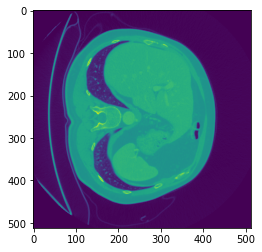

In [6]:
##### Show One of the Input Images
imageNumber = 12
plt.imshow(np.squeeze(X_train[imageNumber, :, :], 2))

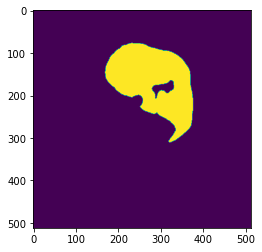

In [7]:
##### Show its Mask
plt.imshow(np.squeeze(Y_train[imageNumber, :, :], 2))

In [8]:
##### Define Loss and Metric
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [9]:
##### Define U-Net Model
inputs = Input((X_train.shape[1], X_train.shape[2], 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

## Load current weights (if desired)
model.load_weights("weights.h5")

model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

In [10]:
##### Train the Model
## Note that 1 epoch has been used - this is so that it can be trained in stages (given the time it takes to train)
## The latest weights can be loaded in the previous step
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
History = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=3, batch_size=10, callbacks=[model_checkpoint])

Epoch 1/3
146/146 [==============================] - 2370s 16s/step - loss: -0.9473 - dice_coef: 0.9473 - val_loss: -0.9566 - val_dice_coef: 0.9570
Epoch 2/3
146/146 [==============================] - 2368s 16s/step - loss: -0.9598 - dice_coef: 0.9598 - val_loss: -0.9502 - val_dice_coef: 0.9505
Epoch 3/3
146/146 [==============================] - 2372s 16s/step - loss: -0.9665 - dice_coef: 0.9665 - val_loss: -0.9648 - val_dice_coef: 0.9651


In [11]:
##### Get Masks of Test Set Images
imgs_mask_test = model.predict(X_test, verbose=1)

6/6 [==============================] - 63s 10s/step


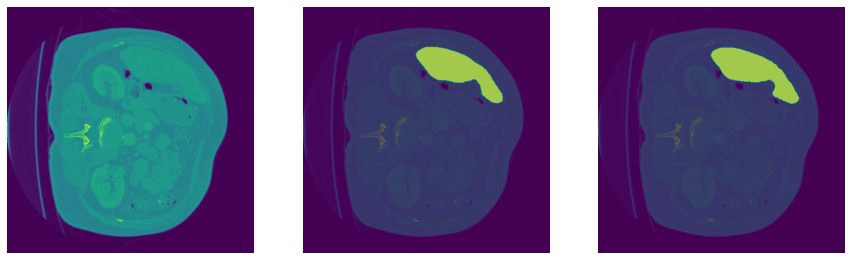

In [13]:
##### Look at Some Segmentations
imageNumber = 12;
#####
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

image = np.squeeze(X_test[imageNumber, :, :], 2)
mask = np.squeeze(imgs_mask_test[imageNumber, :, :], 2)
maskGT = np.squeeze(Y_test[imageNumber, :, :], 2)

axarr[0].imshow(image)
#Show the maks or edges_pz in your case
axarr[1].imshow(mask)
axarr[1].imshow(image, alpha=0.4)

#Show the image with combined mask and the original image, the shape of both image and mask should be same. 
axarr[2].imshow(maskGT)
axarr[2].imshow(image, alpha=0.4)